In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from collections import defaultdict
from collections import  Counter
from nltk.corpus import stopwords
import warnings 
warnings.filterwarnings('ignore')
import re
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM, GRU
from tensorflow.keras import regularizers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud 
from keras.layers import Dense,Dropout,LSTM,SimpleRNN,Embedding,Bidirectional,LSTM,GlobalMaxPool1D
from tensorflow.keras.regularizers import l2

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Basic Information about our Data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


In [8]:
print('Null values in train data\n\n',train.isnull().sum())

Null values in train data

 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [9]:
print('Null values in test data\n\n',test.isnull().sum())

Null values in test data

 id             0
keyword       26
location    1105
text           0
dtype: int64


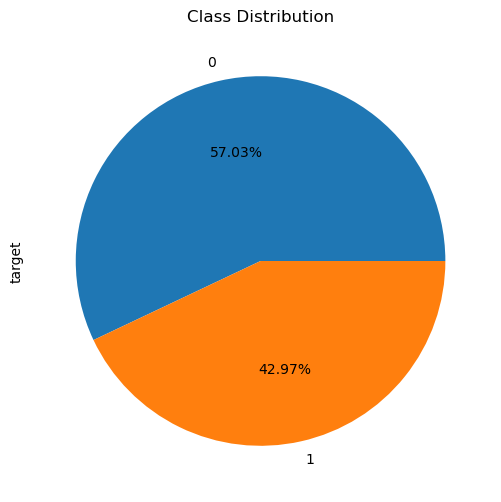

In [10]:
train['target'].value_counts().plot(figsize=(6,6),kind='pie',autopct='%.2f%%')
plt.title('Class Distribution')
plt.show()

We can see that there are more tweets with class 0 ( No disaster) than class 1 ( disaster tweets) 

# Commons Stopwords in tweets

In [11]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

stop=set(stopwords.words('english'))

<BarContainer object of 10 artists>

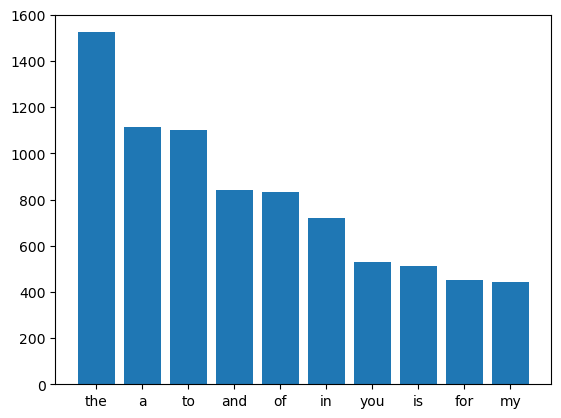

In [12]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

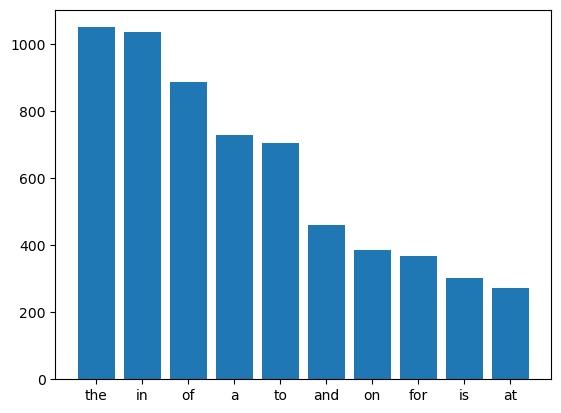

In [13]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

# Analyzing and visualizing punctuations

<BarContainer object of 18 artists>

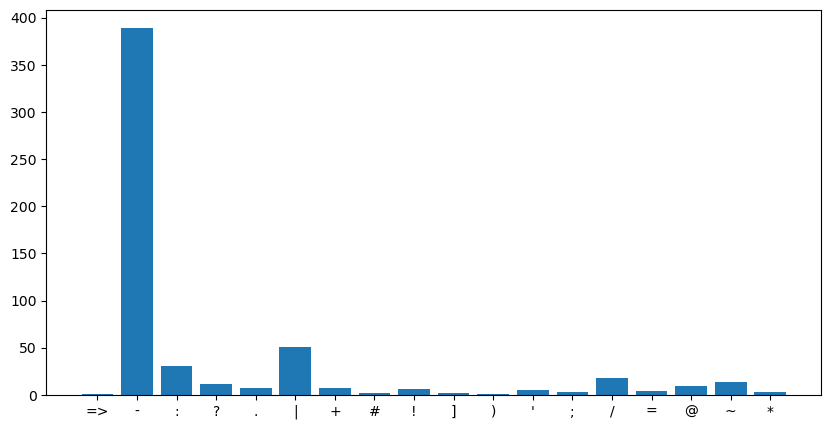

In [14]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

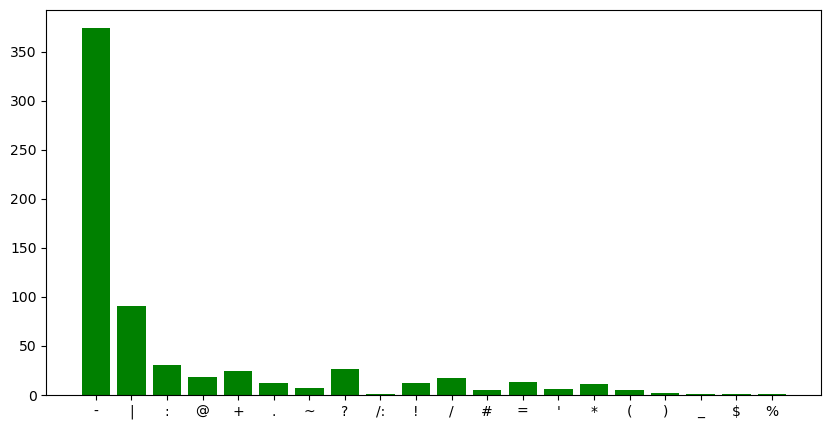

In [15]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

# Text Preprocessing

In [16]:
#df=pd.concat([train,test])

In [17]:
# REMOVING URLS
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

train['text']=train['text'].apply(lambda x : remove_URL(x))
test['text']=test['text'].apply(lambda x : remove_URL(x))

In [18]:
# Removing HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

train['text']=train['text'].apply(lambda x : remove_html(x))
test['text']=test['text'].apply(lambda x : remove_html(x))

In [19]:
# Removing Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train['text']=train['text'].apply(lambda x: remove_emoji(x))
test['text']=test['text'].apply(lambda x: remove_emoji(x))

In [20]:
# Creating a Function clean_text for text preprocessing

def clean_text(text):
    stop = stopwords.words('english')       
    punc = list(punctuation)
    bad_tokens = stop + punc
    lemma = WordNetLemmatizer()
    tokens = word_tokenize(text)
    word_tokens = [t for t in tokens if t.isalpha()]
    clean_token = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in bad_tokens]
    return " ".join(clean_token)

train['text']=train['text'].apply(lambda x: clean_text(x))
test['text']=test['text'].apply(lambda x: clean_text(x))

# WordCloud

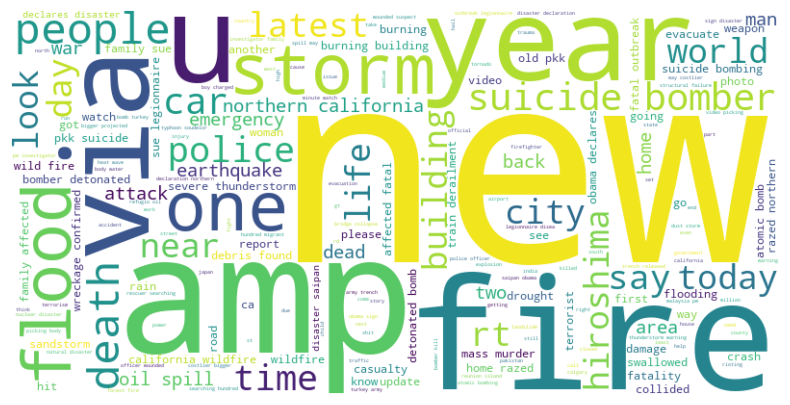

In [21]:
# Wordcloud for where class is 1 or tweets where there is disaster
text_corpus = ' '.join(train[train['target']==1]['text'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

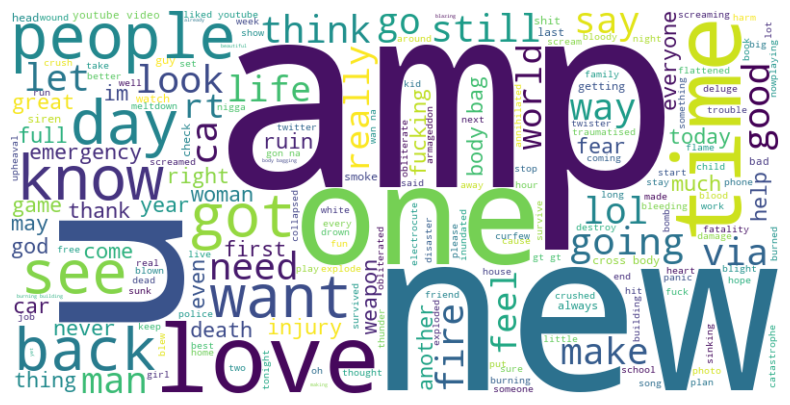

In [22]:
# Wordcloud for where class is 0 or tweets where there is no disaster
text_corpus = ' '.join(train[train['target']==0]['text'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Splitting target and feature columns

In [23]:
x = train['text']
y = train['target']

In [24]:
# Train Test Split

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,random_state=1,test_size=0.2,stratify=y)

# Checking No. of words in each sentence of Review column

In [25]:
sent_len =[]
for sent in train['text']:
    sent_len.append(len(word_tokenize(sent)))
    
train['sent_len'] = sent_len
train.head()

,id,keyword,location,text,target,sent_len
0,1,NaN,NaN,our deed reason earthquake may allah forgive u,1,8
1,4,NaN,NaN,forest fire near la ronge sask canada,1,7
2,5,NaN,NaN,all resident asked place notified officer no e...,1,12
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1,6
4,7,NaN,NaN,just got sent photo ruby alaska smoke wildfire...,1,10


In [26]:
# Checking the reveiw with max no. of words

max(sent_len)

27

In [27]:
pd.set_option('display.max_rows', None)
print(train['sent_len'].value_counts())

9     770
10    759
11    739
8     679
7     662
12    609
13    590
6     561
5     433
14    405
4     341
15    288
3     227
16    149
2     134
17    106
1      53
18     51
19     25
23      9
20      7
22      6
21      4
0       3
27      1
25      1
24      1
Name: sent_len, dtype: int64


In [28]:
# Removing 5% of data beacuse not all sentence length is 39 which is our max sent_len.

np.quantile(sent_len,0.95)

15.0

In [29]:
max_len = 15

# Tokenization, Vectorization & Padding Sequence

In [30]:
# Word tokenize on basis of spacing between each words

tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(xtrain)

In [31]:
# Index of all unique tokenized words 

tok.index_word

{1: 'i',
 2: 'the',
 3: 'a',
 4: 'like',
 5: 'fire',
 6: 'amp',
 7: 'get',
 8: 'new',
 9: 'via',
 10: 'one',
 11: 'u',
 12: 'people',
 13: 'in',
 14: 'news',
 15: 'video',
 16: 'emergency',
 17: 'it',
 18: 'disaster',
 19: 'time',
 20: 'year',
 21: 'police',
 22: 'body',
 23: 'home',
 24: 'would',
 25: 'building',
 26: 'say',
 27: 'day',
 28: 'this',
 29: 'you',
 30: 'family',
 31: 'crash',
 32: 'to',
 33: 'is',
 34: 'my',
 35: 'storm',
 36: 'got',
 37: 'still',
 38: 'go',
 39: 'burning',
 40: 'california',
 41: 'world',
 42: 'back',
 43: 'death',
 44: 'life',
 45: 'suicide',
 46: 'look',
 47: 'bomb',
 48: 'train',
 49: 'know',
 50: 'car',
 51: 'see',
 52: 'ca',
 53: 'man',
 54: 'rt',
 55: 'love',
 56: 'flood',
 57: 'make',
 58: 'youtube',
 59: 'going',
 60: 'attack',
 61: 'of',
 62: 'killed',
 63: 'first',
 64: 'accident',
 65: 'and',
 66: 'two',
 67: 'nuclear',
 68: 'dead',
 69: 'let',
 70: 'need',
 71: 'today',
 72: 'if',
 73: 'war',
 74: 'want',
 75: 'we',
 76: 'could',
 77: 'take'

In [32]:
# Total No. of unique words in our data 

vocab_len = len(tok.index_word)
vocab_len

12073

In [33]:
# Putting all index/unique id of each words in a sequence according to the data

sequences_train = tok.texts_to_sequences(xtrain)
sequences_train

[[1849, 498, 858, 921, 2620, 858, 921, 472, 1630, 216, 273],
 [1224, 130, 71, 2621, 499, 525, 2142, 618, 1850, 2622, 57, 859],
 [4921, 1851, 4922, 346, 6, 3392, 922, 3393, 2623, 114],
 [473, 473, 2143, 366, 983, 1466, 1852, 860, 246, 1631, 1853, 923, 22, 4923],
 [4924, 32, 157, 1058, 2624, 189, 557, 137, 4, 2, 190, 4925, 13],
 [2, 809, 175, 303, 4926, 9, 58],
 [697,
  88,
  2625,
  2144,
  2145,
  61,
  1467,
  1333,
  1854,
  2146,
  115,
  1334,
  261,
  697,
  924,
  347,
  2626],
 [4927, 414, 984, 274, 415, 392, 183, 746, 392, 392],
 [55, 2, 348, 4928, 4929, 4930],
 [2627, 1335, 3394, 1632, 861, 262, 18, 130, 3395, 3396, 393],
 [72, 52, 4931, 169, 526, 6],
 [230, 247, 1468, 3397, 1059, 925, 1060, 4],
 [54, 2147, 164, 446, 747, 197],
 [89, 176, 1136, 1855, 184, 20, 158, 53, 1469, 810, 321],
 [1856,
  619,
  367,
  985,
  157,
  4932,
  38,
  322,
  217,
  20,
  474,
  1470,
  4933,
  1857,
  1225,
  12,
  97],
 [8,
  1858,
  1336,
  1858,
  218,
  2628,
  1858,
  1633,
  2629,
  119

In [34]:
# Padding Sequence

sequence_matrix_train = sequence.pad_sequences(sequences_train,maxlen=max_len)
sequence_matrix_train

array([[   0,    0,    0, ..., 1630,  216,  273],
       [   0,    0,    0, ..., 2622,   57,  859],
       [   0,    0,    0, ..., 3393, 2623,  114],
       ...,
       [ 444,  337,  281, ...,   31,  294,  535],
       [   0,    0,    0, ..., 1258,  437,  209],
       [   0,    0,    0, ...,  873,    9, 1224]])

In [35]:
# Giving each unique tokens/word a unique Id or index and the apply padding sequence

sequence_matrix_test = sequence.pad_sequences(tok.texts_to_sequences(xtest),maxlen=max_len)

# Model Building (Neural Network)

In [36]:
model = Sequential()
model.add(Embedding(vocab_len + 1, 100, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(20, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.30))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.30))
model.add(Dense(15, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.10))
model.add(Dense(1, kernel_regularizer=l2(0.01)))

In [37]:
# Summary of our model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           1207400   
                                                                 
 bidirectional (Bidirection  (None, 15, 40)            19360     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 40)            0         
                                                                 
 global_max_pooling1d (Glob  (None, 40)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 15)                6

In [38]:
# Compile our Model

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
# Training our model

trained_model = model.fit(sequence_matrix_train,ytrain,epochs=10)

Epoch 1/10
191/191 [==============================] - 11s 23ms/step - loss: 3.5023 - accuracy: 0.5703
Epoch 2/10
191/191 [==============================] - 4s 22ms/step - loss: 2.5017 - accuracy: 0.5703
Epoch 3/10
191/191 [==============================] - 4s 22ms/step - loss: 2.0484 - accuracy: 0.5706
Epoch 4/10
191/191 [==============================] - 4s 20ms/step - loss: 1.7274 - accuracy: 0.6039
Epoch 5/10
191/191 [==============================] - 4s 21ms/step - loss: 1.4887 - accuracy: 0.6706
Epoch 6/10
191/191 [==============================] - 4s 21ms/step - loss: 1.2944 - accuracy: 0.7333
Epoch 7/10
191/191 [==============================] - 4s 21ms/step - loss: 1.1311 - accuracy: 0.7837
Epoch 8/10
191/191 [==============================] - 4s 22ms/step - loss: 0.9968 - accuracy: 0.8287
Epoch 9/10
191/191 [==============================] - 4s 22ms/step - loss: 0.8709 - accuracy: 0.8603
Epoch 10/10
191/191 [==============================] - 4s 22ms/step - loss: 0.7814 - accur

In [40]:
# Checking Training and Testing loss 

print('Training_loss :',model.evaluate(sequence_matrix_train,ytrain))
print('Testing_loss :',model.evaluate(sequence_matrix_test,ytest))

191/191 [==============================] - 2s 2ms/step - loss: 0.7312 - accuracy: 0.8989
Training_loss : [0.7311528325080872, 0.8988505601882935]
48/48 [==============================] - 0s 2ms/step - loss: 1.0488 - accuracy: 0.7551
Testing_loss : [1.0488147735595703, 0.7550886273384094]
